In [1]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import hvplot.pandas
import requests
import json
from pathlib import Path
from scipy.stats import linregress

# Import the API key
from config import geoapify_key

In [2]:
# Read in the 2024 WH Data
file = Path("Resources/WH_data_2024.csv")
wh_df = pd.read_csv(file, encoding = "utf-8")
wh_df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268


In [3]:
#Rename columns to more meaningful and consistent names
wh_df = wh_df.rename(columns={"Country name":"Country",
                              "year":"Year",
                              "Social support":"Social Support",
                              "Log GDP per capita":"GDP per capita",
                             "Healthy life expectancy at birth":"Life Expectancy",
                             "Freedom to make life choices":"Freedom",
                             "Perceptions of corruption":"Corruption"})
wh_df.head()

,Country,Year,Life Ladder,GDP per capita,Social Support,Life Expectancy,Freedom,Generosity,Corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268


In [4]:
#Identify incomplete rows
wh_df.count()

Country            2363
Year               2363
Life Ladder        2363
GDP per capita     2335
Social Support     2350
Life Expectancy    2300
Freedom            2327
Generosity         2282
Corruption         2238
Positive affect    2339
Negative affect    2347
dtype: int64

In [5]:
# Drop all rows with missing information
wh_df = wh_df.dropna(how="any")
wh_df.count()


Country            2097
Year               2097
Life Ladder        2097
GDP per capita     2097
Social Support     2097
Life Expectancy    2097
Freedom            2097
Generosity         2097
Corruption         2097
Positive affect    2097
Negative affect    2097
dtype: int64

In [6]:
#Count values by year.  Keep years >= 2013.
wh_df['Year'].value_counts().sort_index()

Year
2005      1
2006     74
2007     91
2008    100
2009    105
2010    111
2011    132
2012    121
2013    124
2014    129
2015    128
2016    125
2017    132
2018    129
2019    129
2020    105
2021    114
2022    127
2023    120
Name: count, dtype: int64

In [7]:
#Only keep data for 2013 to 2023
wh_df = wh_df.loc[wh_df["Year"] >= 2013]

#Get data for just 2023
wh_df_2023 = wh_df.loc[wh_df["Year"]==2023]

#Get data for just 2013
wh_df_2013 = wh_df.loc[wh_df["Year"]==2013]

#Get data for 2023 to be merged with data for 2013 in order to determine changes
wh_df_23 = wh_df.loc[wh_df["Year"]==2023, :]
wh_df_23 = wh_df_23.rename(columns={"Life Ladder":"Life Ladder 2023",
                                   "GDP per capita": "GDP per capita 2023",
                                    "Social Support":"Social Support 2023",
                                    "Life Expectancy":"Life Expectancy 2023",
                                    "Freedom":"Freedom 2023",
                                    "Generosity":"Generosity 2023",
                                    "Corruption":"Corruption 2023",
                                    "Positive affect":"Positive affect 2023",
                                    "Negative affect":"Negative affect 2023"})

#Get data for 2013 to be merged with data for 2023 in order to determine changes
wh_df_13 = wh_df.loc[wh_df["Year"]==2013, :]
wh_df_13 = wh_df_13.rename(columns={"Life Ladder":"Life Ladder 2013",
                                   "GDP per capita": "GDP per capita 2013",
                                    "Social Support":"Social Support 2013",
                                    "Life Expectancy":"Life Expectancy 2013",
                                    "Freedom":"Freedom 2013",
                                    "Generosity":"Generosity 2013",
                                    "Corruption":"Corruption 2013",
                                    "Positive affect":"Positive affect 2013",
                                    "Negative affect":"Negative affect 2013"})

#Merge the data for 2013 and 2023
wh_df_merge = pd.merge(wh_df_13, wh_df_23, on="Country", how="inner")


#Calculate the Life Ladder Change % between the years 2013 and 2023
wh_df_merge["Life Ladder Change %"] = (wh_df_merge["Life Ladder 2023"] - wh_df_merge["Life Ladder 2013"])/(wh_df_merge["Life Ladder 2013"])
wh_df_merge["GDP Change %"] = (wh_df_merge["GDP per capita 2023"] - wh_df_merge["GDP per capita 2013"])/(wh_df_merge["GDP per capita 2013"])
wh_df_merge["Social Support Change %"] = (wh_df_merge["Social Support 2023"] - wh_df_merge["Social Support 2013"])/(wh_df_merge["Social Support 2013"])
wh_df_merge["Life Expectancy Change %"] = (wh_df_merge["Life Expectancy 2023"] - wh_df_merge["Life Expectancy 2013"])/(wh_df_merge["Life Expectancy 2013"])
wh_df_merge["Freedom Change %"] = (wh_df_merge["Freedom 2023"] - wh_df_merge["Freedom 2013"])/(wh_df_merge["Freedom 2013"])
wh_df_merge["Generosity Change %"] = (wh_df_merge["Generosity 2023"] - wh_df_merge["Generosity 2013"])/(wh_df_merge["Generosity 2013"])
wh_df_merge["Corruption Change %"] = (wh_df_merge["Corruption 2023"] - wh_df_merge["Corruption 2013"])/(wh_df_merge["Corruption 2013"])
wh_df_merge["Positive affect Change %"] = (wh_df_merge["Positive affect 2023"] - wh_df_merge["Positive affect 2013"])/(wh_df_merge["Positive affect 2013"])
wh_df_merge["Negative affect Change %"] = (wh_df_merge["Negative affect 2023"] - wh_df_merge["Negative affect 2013"])/(wh_df_merge["Negative affect 2013"])

#Sort in descending order
wh_df_merge = wh_df_merge.sort_values(by="Life Ladder Change %",ascending=False).reset_index()

#Check results
wh_df_merge.head()


,index,Country,Year_x,Life Ladder 2013,GDP per capita 2013,Social Support 2013,Life Expectancy 2013,Freedom 2013,Generosity 2013,Corruption 2013,...,Negative affect 2023,Life Ladder Change %,GDP Change %,Social Support Change %,Life Expectancy Change %,Freedom Change %,Generosity Change %,Corruption Change %,Positive affect Change %,Negative affect Change %
0,50,Ivory Coast,2013,3.739,8.285,0.709,51.30,0.739,-0.037,0.691,...,0.307,0.427387,0.044780,-0.121298,0.113060,0.018945,0.540541,-0.021708,0.013616,0.003268
1,13,Bulgaria,2013,3.993,9.848,0.829,65.62,0.603,-0.199,0.962,...,0.192,0.399950,0.043156,0.127865,0.016458,0.250415,-0.341709,-0.014553,0.003724,-0.309353
2,85,Senegal,2013,3.647,7.943,0.823,57.60,0.636,-0.058,0.837,...,0.258,0.396490,0.032356,-0.188335,0.052083,0.254717,-1.827586,-0.001195,0.188761,0.563636
3,90,South Africa,2013,3.661,9.548,0.839,52.30,0.714,-0.089,0.800,...,0.255,0.386506,-0.004713,0.000000,0.114723,0.047619,0.224719,0.076250,-0.043243,0.526946
4,34,Gabon,2013,3.800,9.593,0.733,55.38,0.682,-0.148,0.780,...,0.424,0.343158,-0.004065,0.002729,0.063561,0.058651,0.081081,0.053846,0.194605,0.477352


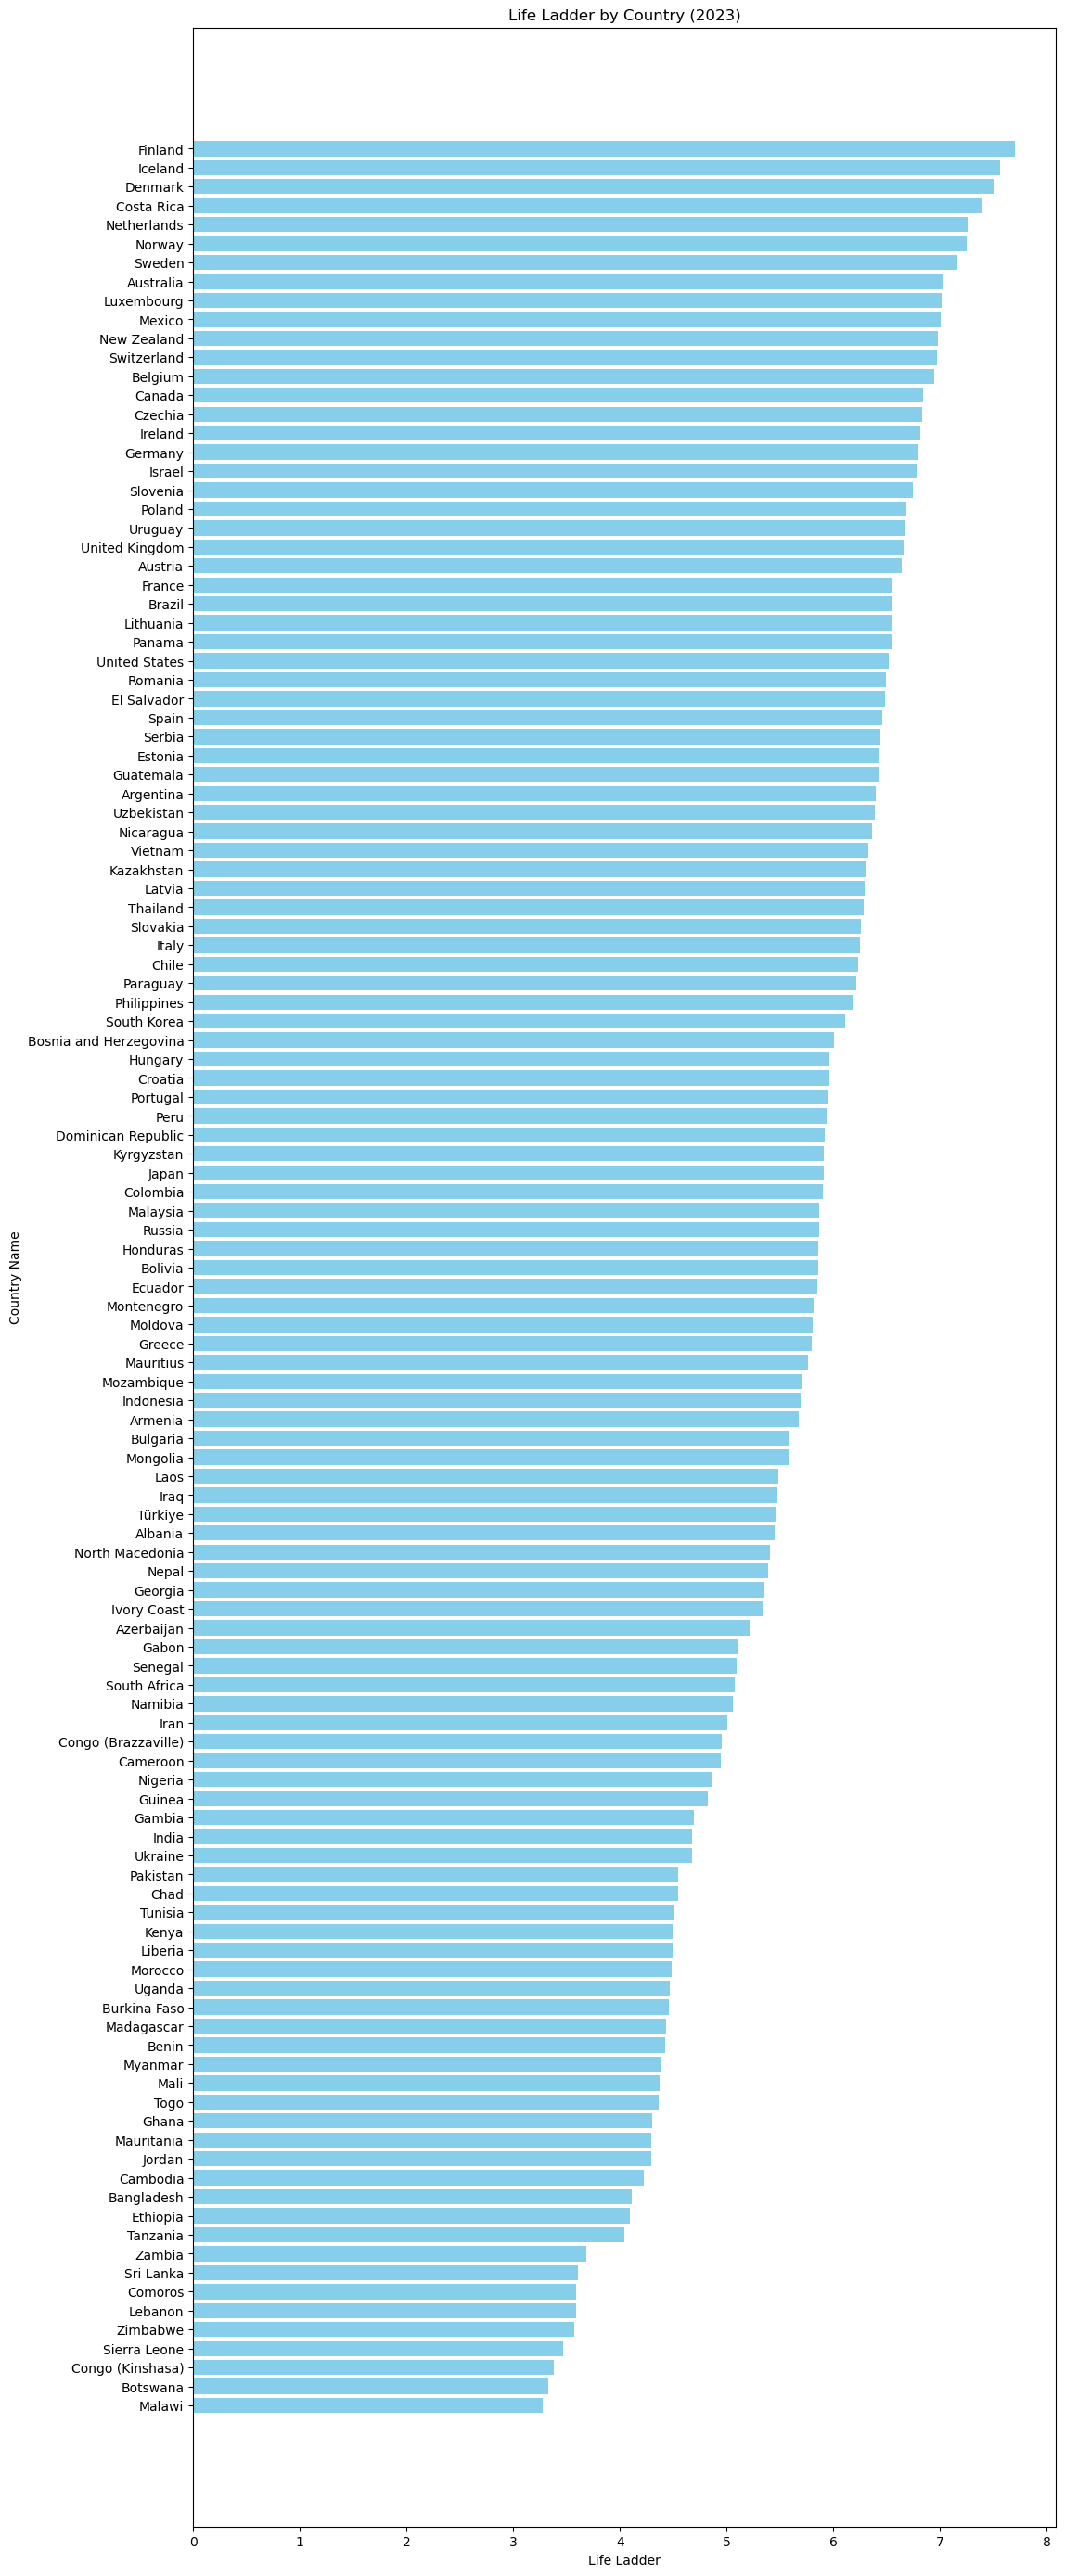

In [8]:
# Create a bar chart showing life ladder score for every country. 

# Sort the DataFrame by 'Life Ladder' so the chart shows highest to lowest
wh_df_2023_sorted = wh_df_2023.sort_values(by='Life Ladder', ascending=True)

# Create the bar plot
plt.figure(figsize=(12, 35))  # Adjust the figure size as needed
plt.barh(wh_df_2023_sorted['Country'], wh_df_2023_sorted['Life Ladder'], color='skyblue')

# Add labels and title
plt.xlabel('Life Ladder')
plt.ylabel('Country Name')
plt.title('Life Ladder by Country (2023)')

# Show the plot
plt.show()

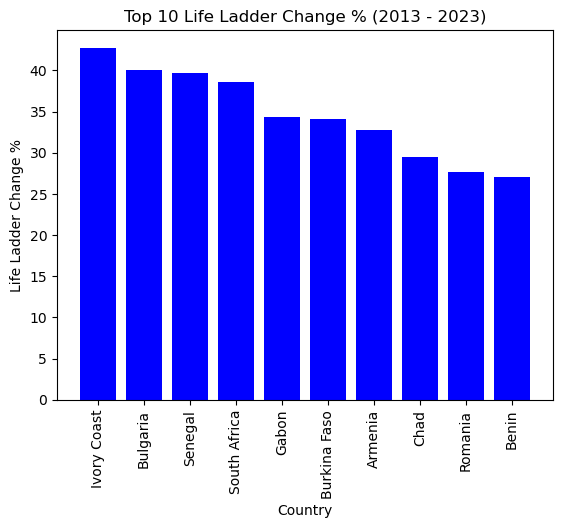

In [9]:
#Get the countries with the top Life Ladder Change %
top_indices = wh_df_merge["Life Ladder Change %"].nlargest(10).index
top_rows = wh_df_merge.loc[top_indices]


#Create the bar chart
plt.bar(top_rows["Country"], top_rows["Life Ladder Change %"]*100, color='b')
plt.xticks(rotation=90)
plt.title("Top 10 Life Ladder Change % (2013 - 2023)")
plt.xlabel("Country")
plt.ylabel("Life Ladder Change %")
plt.show()

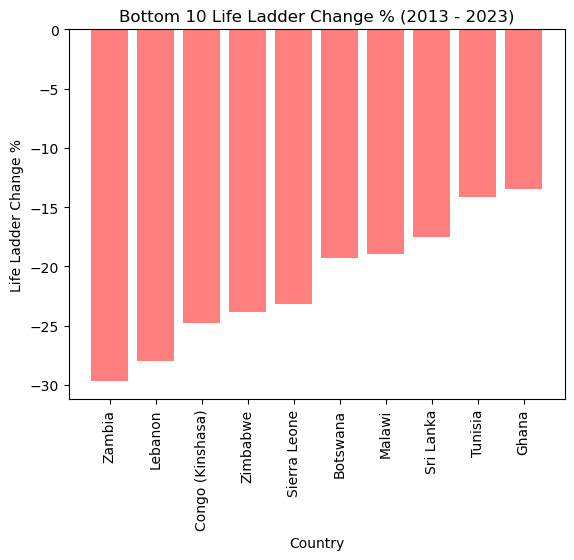

In [10]:
#Get the countries with the bottom Life Ladder Change %
bottom_indices = wh_df_merge["Life Ladder Change %"].nsmallest(10).index
bottom_rows = wh_df_merge.loc[bottom_indices]

#Create the bar chart
plt.bar(bottom_rows["Country"], bottom_rows["Life Ladder Change %"]*100, color='r', alpha=0.5, align="center")
plt.xticks(rotation=90)
plt.title("Bottom 10 Life Ladder Change % (2013 - 2023)")
plt.xlabel("Country")
plt.ylabel("Life Ladder Change %")
plt.show()

In [12]:
#Happiness Factors

The r^2-value is: 0.6273722804997797


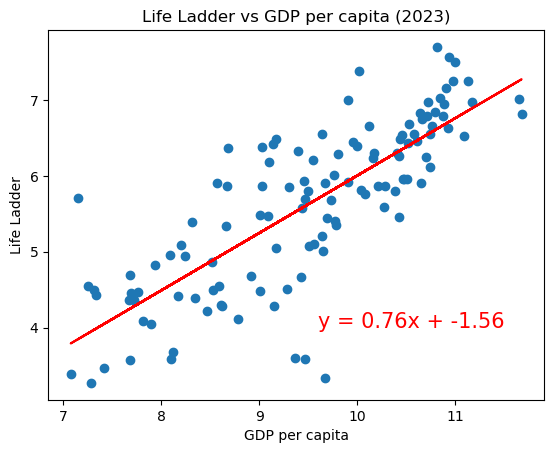

In [14]:
# Linear regression on Life Ladder vs GDP for 2023
x_values = wh_df_2023["GDP per capita"]
y_values = wh_df_2023["Life Ladder"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(9.6,4),fontsize=15,color="red")
plt.title("Life Ladder vs GDP per capita (2023)")
plt.xlabel("GDP per capita")
plt.ylabel("Life Ladder")
print(f"The r^2-value is: {rvalue**2}")
plt.show()

The r^2-value is: 0.6417828961767855


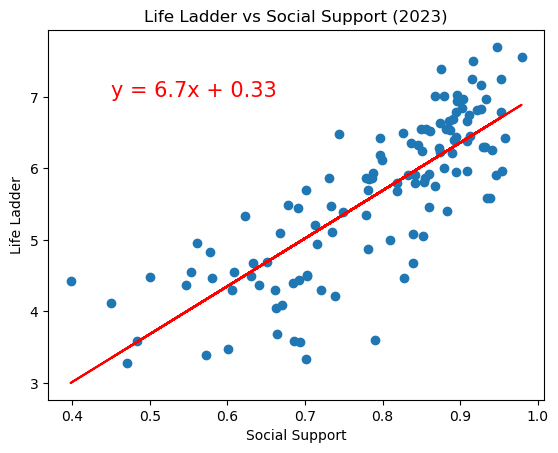

In [16]:
# Linear regression on Life Ladder vs Social Support for 2023
x_values = wh_df_2023["Social Support"]
y_values = wh_df_2023["Life Ladder"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0.45,7),fontsize=15,color="red")
plt.title("Life Ladder vs Social Support (2023)")
plt.xlabel("Social Support")
plt.ylabel("Life Ladder")
print(f"The r^2-value is: {rvalue**2}")
plt.show()

The r^2-value is: 0.5671855170383211


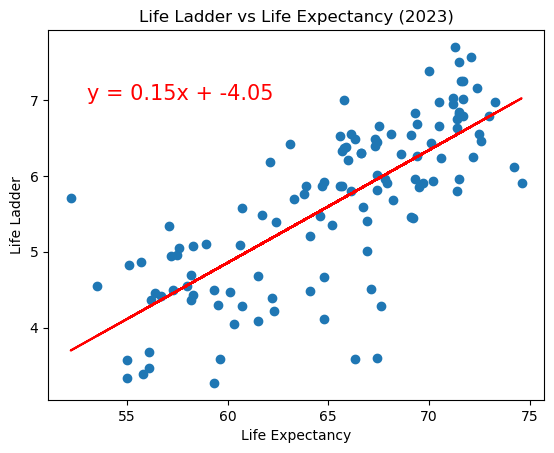

In [18]:
# Linear regression on Life Ladder vs Life Expectancy for 2023
x_values = wh_df_2023["Life Expectancy"]
y_values = wh_df_2023["Life Ladder"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(53,7),fontsize=15,color="red")
plt.title("Life Ladder vs Life Expectancy (2023)")
plt.xlabel("Life Expectancy")
plt.ylabel("Life Ladder")
print(f"The r^2-value is: {rvalue**2}")
plt.show()

The r^2-value is: 0.30872005723145524


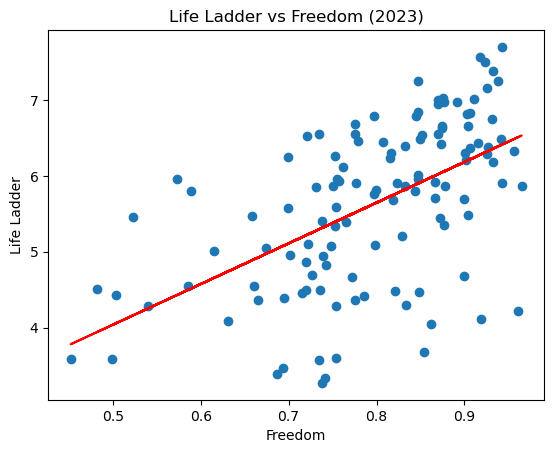

In [20]:
# Linear regression on Life Ladder vs Freedom for 2023
x_values = wh_df_2023["Freedom"]
y_values = wh_df_2023["Life Ladder"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(53,7),fontsize=15,color="red")
plt.title("Life Ladder vs Freedom (2023)")
plt.xlabel("Freedom")
plt.ylabel("Life Ladder")
print(f"The r^2-value is: {rvalue**2}")
plt.show()

The r^2-value is: 5.2109028433641155e-05


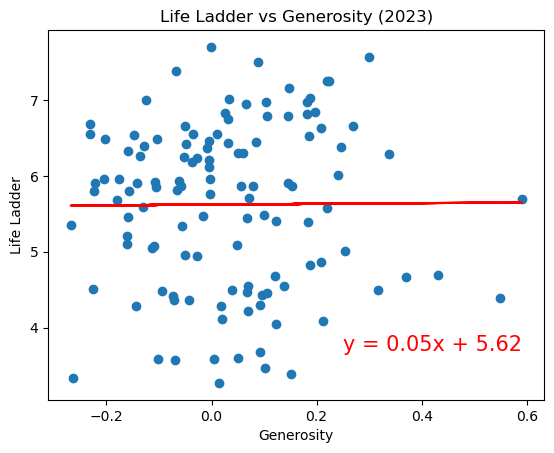

In [22]:
# Linear regression on Life Ladder vs Generosity for 2023
x_values = wh_df_2023["Generosity"]
y_values = wh_df_2023["Life Ladder"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0.25,3.7),fontsize=15,color="red")
plt.title("Life Ladder vs Generosity (2023)")
plt.xlabel("Generosity")
plt.ylabel("Life Ladder")
print(f"The r^2-value is: {rvalue**2}")
plt.show()

The r^2-value is: 0.24206280025588345


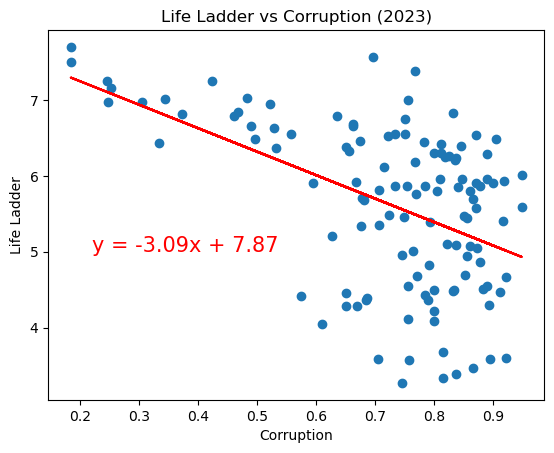

In [24]:
# Linear regression on Life Ladder vs Corruption for 2023
x_values = wh_df_2023["Corruption"]
y_values = wh_df_2023["Life Ladder"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(.22,5),fontsize=15,color="red")
plt.title("Life Ladder vs Corruption (2023)")
plt.xlabel("Corruption")
plt.ylabel("Life Ladder")
print(f"The r^2-value is: {rvalue**2}")
plt.show()

The r^2-value is: 0.22273450358160132


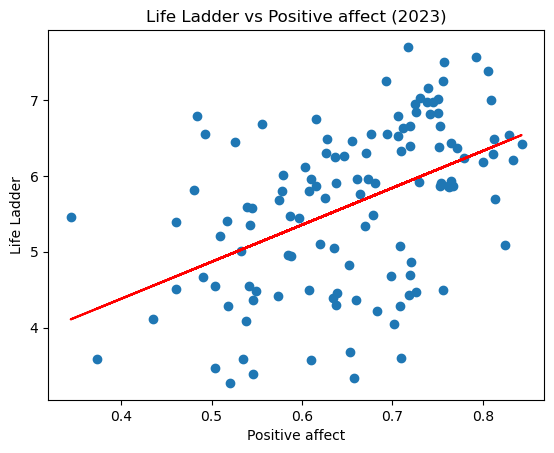

In [26]:
# Linear regression on Life Ladder vs Positive affect for 2023
x_values = wh_df_2023["Positive affect"]
y_values = wh_df_2023["Life Ladder"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(.22,5),fontsize=15,color="red")
plt.title("Life Ladder vs Positive affect (2023)")
plt.xlabel("Positive affect")
plt.ylabel("Life Ladder")
print(f"The r^2-value is: {rvalue**2}")
plt.show()

The r^2-value is: 0.2817374509043864


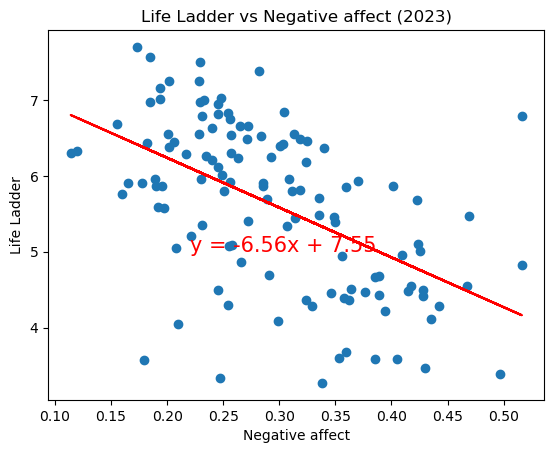

In [28]:
# Linear regression on Life Ladder vs Negative affect for 2023
x_values = wh_df_2023["Negative affect"]
y_values = wh_df_2023["Life Ladder"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(.22,5),fontsize=15,color="red")
plt.title("Life Ladder vs Negative affect (2023)")
plt.xlabel("Negative affect")
plt.ylabel("Life Ladder")
print(f"The r^2-value is: {rvalue**2}")
plt.show()

The r^2-value is: 0.7585990269590229


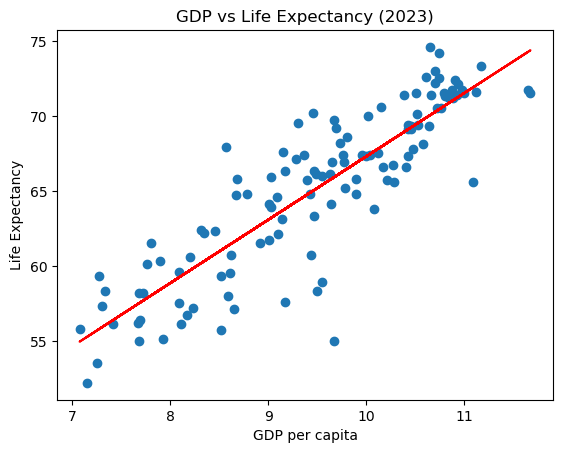

In [30]:
# Linear regression on GDP vs Life Expectancy affect for 2023
x_values = wh_df_2023["GDP per capita"]
y_values = wh_df_2023["Life Expectancy"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(.22,5),fontsize=15,color="red")
plt.title("GDP vs Life Expectancy (2023)")
plt.xlabel("GDP per capita")
plt.ylabel("Life Expectancy")
print(f"The r^2-value is: {rvalue**2}")
plt.show()

The r^2-value is: 0.11848409201068281


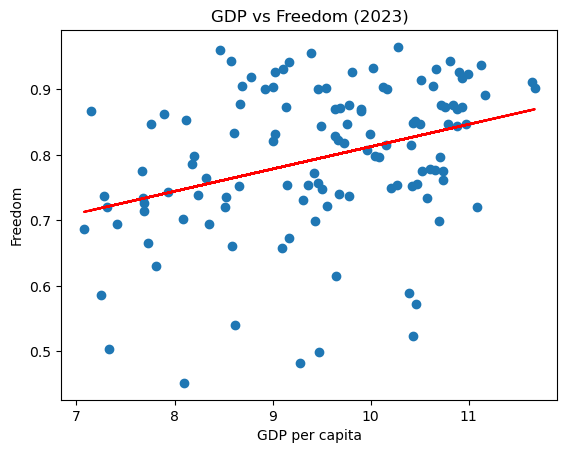

In [32]:
# Linear regression on GDP vs Freedom for 2023
x_values = wh_df_2023["GDP per capita"]
y_values = wh_df_2023["Freedom"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(.22,5),fontsize=15,color="red")
plt.title("GDP vs Freedom (2023)")
plt.xlabel("GDP per capita")
plt.ylabel("Freedom")
print(f"The r^2-value is: {rvalue**2}")
plt.show()

The r^2-value is: 0.18167168541862375


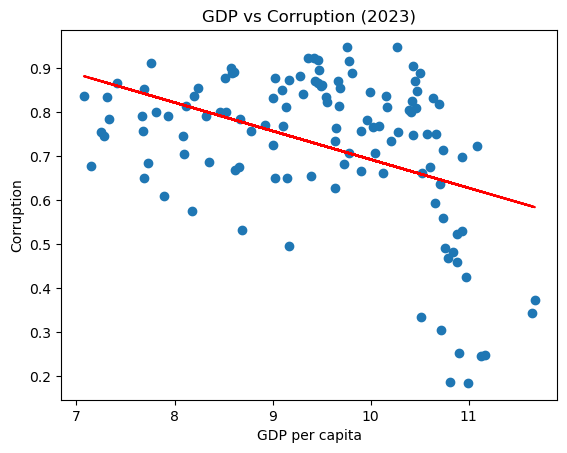

In [34]:
# Linear regression on GDP vs Corruption for 2023
x_values = wh_df_2023["GDP per capita"]
y_values = wh_df_2023["Corruption"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(.22,5),fontsize=15,color="red")
plt.title("GDP vs Corruption (2023)")
plt.xlabel("GDP per capita")
plt.ylabel("Corruption")
print(f"The r^2-value is: {rvalue**2}")
plt.show()

In [38]:
#Geo Analysis

In [40]:
# Find latitude and longitude for each country using the geo API
import requests
import json

# Import the API key
from config import geoapify_key

#Change the country name "Taiwan Provence of China" to just "Taiwan" to allow geoapi to find a result.
wh_df_2023_sorted.loc[wh_df_2023_sorted['Country'] == 'Taiwan Province of China', 'Country'] = 'Taiwan'

# Initialize lists to store latitudes and longitudes
latitudes = []
longitudes = []

# Iterate over each country in the DataFrame
for country in wh_df_2023_sorted['Country']:
    # Build the endpoint URL
    target_url = f"https://api.geoapify.com/v1/geocode/search?country={country}&format=json&apiKey={geoapify_key}"
    
    # Run a request to the endpoint and convert the result to json
    geo_data = requests.get(target_url).json()
    
    # Extract latitude and longitude
    # lat = geo_data["results"][0]["lat"]
    # lon = geo_data["results"][0]["lon"]
    
    if geo_data["results"]:
        lat = geo_data["results"][0]["lat"]
        lon = geo_data["results"][0]["lon"]
    else:
        # Handle the case where no results are returned
        lat = None
        lon = None
        print(f"No geolocation data found for {country}")


    # Append to lists
    latitudes.append(lat)
    longitudes.append(lon)

# Add the latitudes and longitudes to the DataFrame
wh_df_2023_sorted['Latitude'] = latitudes
wh_df_2023_sorted['Longitude'] = longitudes

# Display the updated DataFrame
wh_df_2023_sorted.head()

,Country,Year,Life Ladder,GDP per capita,Social Support,Life Expectancy,Freedom,Generosity,Corruption,Positive affect,Negative affect,Latitude,Longitude
1277,Malawi,2023,3.272,7.279,0.470,59.3,0.738,0.014,0.745,0.520,0.338,-13.268720,33.930196
258,Botswana,2023,3.332,9.673,0.701,55.0,0.741,-0.264,0.814,0.657,0.247,-23.168178,24.592874
472,Congo (Kinshasa),2023,3.383,7.076,0.572,55.8,0.687,0.152,0.837,0.546,0.497,-2.981434,23.822264
1835,Sierra Leone,2023,3.467,7.412,0.601,56.1,0.694,0.101,0.866,0.504,0.430,8.640035,-11.840027
2362,Zimbabwe,2023,3.572,7.679,0.694,55.0,0.735,-0.069,0.757,0.610,0.179,-18.455496,29.746841


In [44]:
# Create a map showing life ladder score for every country.

# Configure the map
life_ladder_map = wh_df_2023_sorted.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 800,
    frame_height = 600,
    size = "Life Ladder",
    scale = 5,
    color = "Country",
    xlim=(-180, 180),  # Adjust x-axis range for longitude
    ylim=(-80, 80)     # Adjust y-axis range for latitude
)

# Display the map plot
life_ladder_map

KeyboardInterrupt: 